In [5]:
#@title Install dependencies and setup SplineCAM

!pip install --upgrade gdown
!git clone https://github.com/AhmedImtiazPrio/splinecam.git

!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25

!echo "deb http://cz.archive.ubuntu.com/ubuntu bionic main universe" >> /etc/apt/sources.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install networkx
!pip install python-igraph>=0.10
!pip install tqdm
!pip install livelossplot

!pip uninstall torch torchvision -y
!pip install --pre torch==1.12+cu116 torchvision -f https://download.pytorch.org/whl/torch_stable.html

!mkdir animation
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Cloning into 'splinecam'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 160 (delta 24), reused 12 (delta 11), pack-reused 126
Receiving objects: 100% (160/160), 53.87 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Executing: /tmp/apt-key-gpghome.0cGazsDO64/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubunt

In [2]:
#@title Hepler Functions and Imports

import sys
sys.path.append('./splinecam')

import splinecam
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch

import time
from livelossplot import PlotLosses
import copy

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None,
                num_epochs=25, save_checkpoints=None, return_best_val=False, checkpoint_path=None):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                continue
                # model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,inputs in enumerate(dataloaders):
                inputs = inputs.to(device) 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs[...,:-1])
                    loss = criterion(outputs, inputs[...,-1:])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step(loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders), loss.item() * inputs.size(0)), end="")

                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes
            if phase == 'train':
                avg_loss = epoch_loss
                val_loss = epoch_loss


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if save_checkpoints is not None and phase== 'val':
                if epoch in save_checkpoints:
                    save_model = copy.deepcopy(model)
                    torch.save(save_model,f'{checkpoint_path}_{epoch}_{epoch_loss:.3f}_{val_loss:.3f}.pt')
                    
                
        liveloss.update({
            'log loss': avg_loss,
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, 0))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    if return_best_val:
        model.load_state_dict(best_model_wts)
        
    return model

def get_mgrid(sidelen):
  
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen    
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from partially initialized module 'gi' (most likely due to a circular import) (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
img = plt.imread('./splinecam/data/metfaces_sample.png').mean(-1)

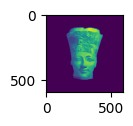

In [4]:
plt.figure(figsize=(1,1))
plt.imshow(img)

# Train INR

### Train an MLP:R2->R1 that maps pixel coordinates to pixel intensities

In [5]:
sidelen = img.shape[0]
x = get_mgrid(sidelen)
y = torch.tensor(img.reshape(-1,1))
inputs = torch.hstack([x,y])

dataloader = torch.utils.data.DataLoader(inputs,
                                         batch_size=128,
                                         pin_memory=True,
                                         shuffle=True)

In [6]:
##model def

width = 50
depth = 5

model = nn.Sequential(
    nn.Linear(2,width),
    nn.LeakyReLU(),
    *[nn.Linear(width,width), nn.LeakyReLU()]*(depth-2),
    nn.Linear(width,1),
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

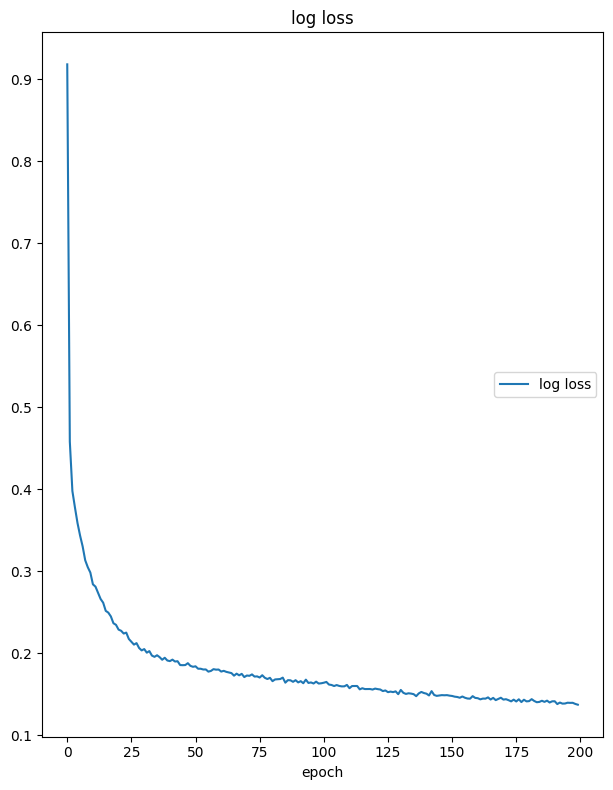

log loss
	log loss         	 (min:    0.137, max:    0.918, cur:    0.137)
Train Loss: 0.1370 Acc: 0.0000

Training complete in 55m 22s


In [9]:
criterion = torch.nn.MSELoss()

model = train_model(model.cuda(),optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=200,
           )

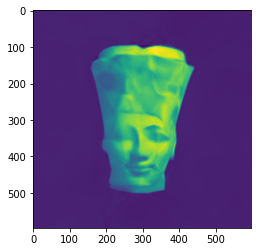

In [ ]:
with torch.no_grad():
    plt.imshow(model.forward(x.cuda()).reshape(sidelen,sidelen).cpu().numpy())

In [8]:
## ROI square domain defined at the model input space
domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

## Get projection matrix for 2D<->input
# T = splinecam.utils.get_proj_mat(domain)
T = torch.eye(3)[:-1]

In [9]:
model.cuda()
model.eval()
model.type(torch.float64)

print('Wrapping model with SplineCam...')
NN = splinecam.wrappers.model_wrapper(
    model,
    input_shape=(2,),
    T = T,
    dtype = torch.float64,
    device = 'cuda'
)

## check .forward() and matmul operation equivalence
print('Verifying wrapped model...')
flag =  NN.verify()
print('Model.forward and matmul equivalence check', flag)
assert flag

Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Verifying wrapped model...
Model.forward and matmul equivalence check True


In [10]:
regions, _ = splinecam.compute.get_partitions_with_db(
      domain,
      T,
      NN,
      fwd_batch_size = 1024,
      batch_size = 128,
      n_workers = 2,
      Abw_batch_size = 16,
)

Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Finding regions from first layer graph


Get Abw: 100%|██████████| 9/9 [00:00<00:00, 34.52it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 262.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 535.72it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 604.16it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 430.58it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 494.16it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 497.94it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 366.37it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 456.66it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 293.17it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 553.45it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 330.35it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 389.07it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 420.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 247.45it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 335.69it/s]

iterating hyps: 100%|██████████| 5/5 [0

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 351.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 423.15it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 487.88it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.45it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 491.57it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 301.41it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 288.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 392.88it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 718.55it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 306.99it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 503.10it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.27it/s]

Get Abw: 100%|██████████| 62/62 [00:00<00:00, 125.21it/s]

Current layer 4



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 277.79it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 241.53it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 417.43it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 544.57it/s]

Get Abw: 100%|██████████| 77/77 [00:00<00:00, 98.56it/s] 

Time elapsed 0.288 minutes


no intersections


100%|██████████| 41482/41482 [00:15<00:00, 2740.38it/s]


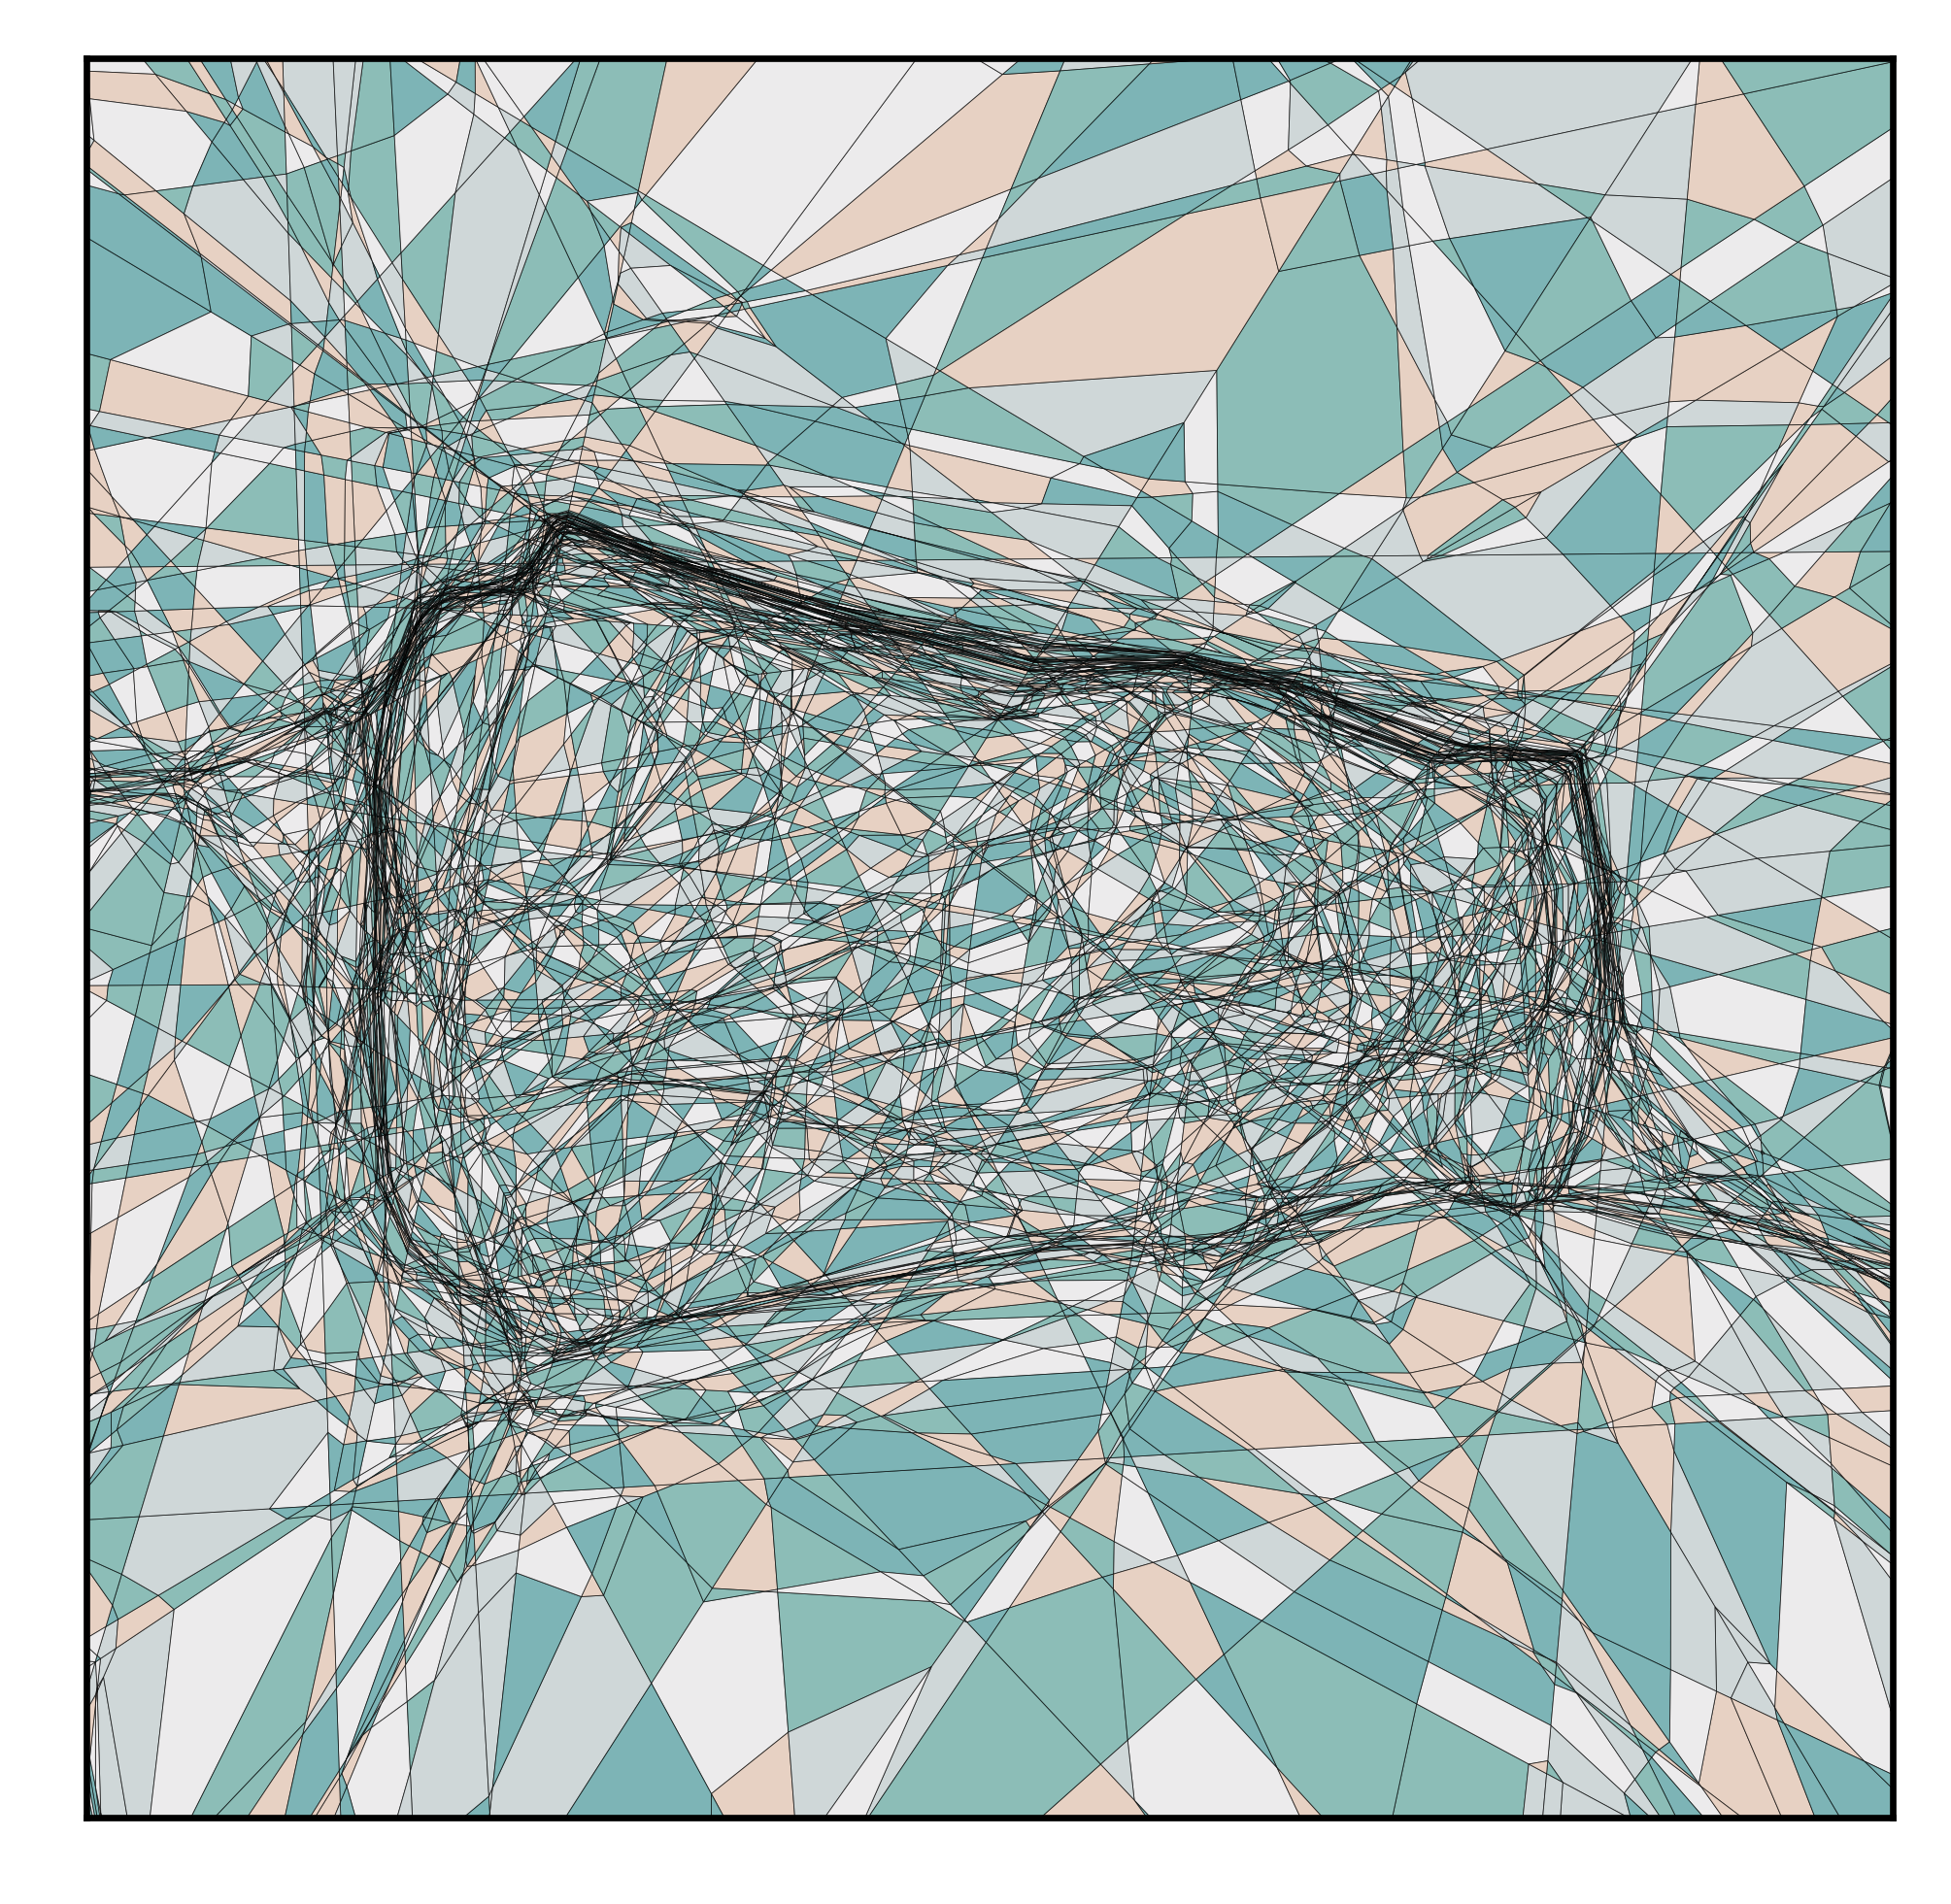

In [ ]:
plt.rcParams['figure.dpi'] = 600
fig,ax = plt.subplots(figsize=(4,4))

minval,_ = torch.vstack(regions).min(0)
maxval,_ = torch.vstack(regions).max(0)

splinecam.plot.plot_partition(regions, xlims=[minval[0],maxval[0]],alpha=.7,
                         edgecolor='k',
#                          color_range=[.3,.8],
                         ax=ax,
                         colors=['#469597', '#5BA199', '#BBC6C8', '#E5E3E4', '#DDBEAA'],
                         ylims=[minval[1],maxval[1]], linewidth=.1)